In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sbn
import networkx as nx 
import networkx.algorithms.community as nxcom
import community as community_louvain
import time
import random
import pickle as pkl

# reproducibility
random.seed(0)
np.random.seed(0)

##  Base Network: Reactome FI

## Annotated Genes: CCLE rna expression features 

## Protein Targets: Targetome kinase inhibitor targets 

*We'll attempt to priortize a set of genes that include the majority of connections between known kinase inhibitor targets* 


In [3]:
fi = pd.read_csv('../data/raw/FIsInGene_020720_with_annotations.txt', sep='\t', header=0)
fi.head()

Gene1    Gene2                    Annotation Direction  Score
0  16-5-5    CDC42                     predicted         -   0.98
1  16-5-5    PARD3                     predicted         -   1.00
2  16-5-5   PARD3B                     predicted         -   1.00
3    A1CF  APOBEC1  catalyzed by; complex; input        <-   1.00
4    A1CF    EP300       expression regulated by        <-   1.00

# edge types 

In [20]:
fi.fillna(-666).groupby('Annotation')['Gene1'].count().sort_values().tail(50)

Annotation
activate; catalyze; catalyzed by; complex; input      359
activated by; inhibited by                            367
PPrel: activation, phosphorylation                    392
PPrel: inhibition                                     395
activate; catalyze                                    410
complex; input; predicted                             429
PPrel: compound                                       450
inhibit                                               507
PPrel: activation, binding/association                525
activate; input                                       637
PPrel: inhibited by, dephosphorylation                666
inhibite                                              674
PPrel: activated, indirect effect                     683
PPrel: binding/association; complex; input            699
catalyze; input                                       717
complex; reaction                                     793
PPrel: activation, indirect effect                    797
act

# What is the gene annotation overlap between `reactome` and `lincs` ?

In [22]:
geneinfo = pd.read_csv('../../LINCS/data/raw/geneinfo_beta.txt', sep='\t')
geneinfo.head()

gene_id gene_symbol       ensembl_id  \
0      750    GAS8-AS1  ENSG00000221819   
1     6315     ATXN8OS              NaN   
2     7503        XIST  ENSG00000229807   
3     8552        INE1  ENSG00000224975   
4     9834      FAM30A  ENSG00000226777   

                                    gene_title gene_type   src feature_space  
0                         GAS8 antisense RNA 1     ncRNA  NCBI      inferred  
1                 ATXN8 opposite strand lncRNA     ncRNA  NCBI      inferred  
2               X inactive specific transcript     ncRNA  NCBI      inferred  
3                        inactivation escape 1     ncRNA  NCBI      inferred  
4  family with sequence similarity 30 member A     ncRNA  NCBI      inferred

In [45]:
with open('../../GENEID_MAPPING/data/processed/all2genesymbol.pkl', 'rb') as f: 
    all2symb = pkl.load(f)

In [52]:
for feat_space in geneinfo.feature_space.unique().tolist() + ['all']: 
    print(f'############ {feat_space} #############')
    if feat_space != 'all': 
        gi = geneinfo[lambda x: x.feature_space == feat_space]
    else: 
        gi = geneinfo
    lincs_genes = set(gi.gene_symbol.tolist())
    react_genes = set(fi.Gene1.tolist()).union(set(fi.Gene2.tolist()))

    if True:
        lincs_genes2 = set([all2symb[str(x).upper()][0] for x in lincs_genes if str(x).upper() in all2ensembl])
        react_genes2 = set([all2symb[str(x).upper()][0] for x in react_genes if str(x).upper() in all2ensembl])
        print('# of lincs genes dropped in ensembl mapping:', len(lincs_genes) - len(lincs_genes2))
        print('# of reactome genes dropped in ensembl mapping:', len(react_genes) - len(react_genes2))
        react_genes = react_genes2 
        lincs_genes = lincs_genes2

    print('# lincs genes:', len(lincs_genes))
    print('# reactome genes:', len(react_genes))
    lincs_and_react_genes = lincs_genes.intersection(react_genes)
    print('# overlapping genes (lincs & reactome)', len(lincs_and_react_genes))
    print(f'\t percentage of reactome:  {len(lincs_and_react_genes)/len(react_genes)*100:.1f}')
    print(f'\t percentage of lincs:     {len(lincs_and_react_genes)/len(lincs_genes)*100:.1f}')

############ inferred #############
# of lincs genes dropped in ensembl mapping: 40
# of reactome genes dropped in ensembl mapping: 533
# lincs genes: 2114
# reactome genes: 13538
# overlapping genes (lincs & reactome) 1582
	 percentage of reactome:  11.7
	 percentage of lincs:     74.8
############ landmark #############
# of lincs genes dropped in ensembl mapping: 10
# of reactome genes dropped in ensembl mapping: 533
# lincs genes: 968
# reactome genes: 13538
# overlapping genes (lincs & reactome) 852
	 percentage of reactome:  6.3
	 percentage of lincs:     88.0
############ best inferred #############
# of lincs genes dropped in ensembl mapping: 121
# of reactome genes dropped in ensembl mapping: 533
# lincs genes: 9075
# reactome genes: 13538
# overlapping genes (lincs & reactome) 7397
	 percentage of reactome:  54.6
	 percentage of lincs:     81.5
############ all #############
# of lincs genes dropped in ensembl mapping: 174
# of reactome genes dropped in ensembl mapping: 533
#

# Functional interaction confidence 

Should we use all interactions or filter by `score`?

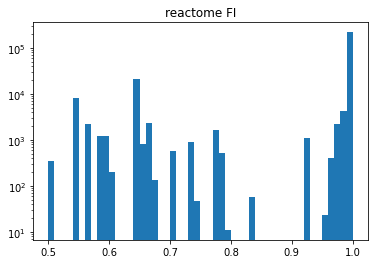

In [5]:
plt.figure()
plt.title('reactome FI')
plt.hist(fi.Score.values,bins=50)
plt.yscale('log')
plt.show()

In [7]:
# how many predicted interactions have confidence less than 0.9
(fi.Score.values < 0.9).sum()

41379

In [8]:
lines = [f'{x}::{y}' for x,y in fi[['Gene1', 'Gene2']].values]
G = nx.parse_edgelist(lines, delimiter='::')

len(G)

14071

In [9]:
# how many discrete / unconnected networks are there?
nx.number_connected_components(G)

#_ = [print(len(x)) for x in nx.connected_components(G)]

84

In [10]:
# one large comp, rest are small (2-4 nodes)
largest_comp = next(nx.connected_components(G))
print('larget comp size:', len(largest_comp))
toremove = G.nodes()-largest_comp
G.remove_nodes_from(toremove)
print('size G:', len(G))

larget comp size: 13877
size G: 13877


In [53]:
for feat_space in geneinfo.feature_space.unique().tolist() + ['all']: 
    print(f'############ {feat_space} #############')
    if feat_space != 'all': 
        gi = geneinfo[lambda x: x.feature_space == feat_space]
    else: 
        gi = geneinfo

    lincs_genes = set(gi.gene_symbol.tolist())
    react_genes = set(G.nodes())

    if True:
        lincs_genes2 = set([all2symb[str(x).upper()][0] for x in lincs_genes if str(x).upper() in all2ensembl])
        react_genes2 = set([all2symb[str(x).upper()][0] for x in react_genes if str(x).upper() in all2ensembl])
        print('# of lincs genes dropped in ensembl mapping:', len(lincs_genes) - len(lincs_genes2))
        print('# of reactome genes dropped in ensembl mapping:', len(react_genes) - len(react_genes2))
        react_genes = react_genes2 
        lincs_genes = lincs_genes2

    print('# lincs genes:', len(lincs_genes))
    print('# reactome genes:', len(react_genes))
    lincs_and_react_genes = lincs_genes.intersection(react_genes)
    print('# overlapping genes (lincs & reactome)', len(lincs_and_react_genes))
    print(f'\t percentage of reactome:  {len(lincs_and_react_genes)/len(react_genes)*100:.1f}')
    print(f'\t percentage of lincs:     {len(lincs_and_react_genes)/len(lincs_genes)*100:.1f}')

############ inferred #############
# of lincs genes dropped in ensembl mapping: 40
# of reactome genes dropped in ensembl mapping: 532
# lincs genes: 2114
# reactome genes: 13345
# overlapping genes (lincs & reactome) 1555
	 percentage of reactome:  11.7
	 percentage of lincs:     73.6
############ landmark #############
# of lincs genes dropped in ensembl mapping: 10
# of reactome genes dropped in ensembl mapping: 532
# lincs genes: 968
# reactome genes: 13345
# overlapping genes (lincs & reactome) 844
	 percentage of reactome:  6.3
	 percentage of lincs:     87.2
############ best inferred #############
# of lincs genes dropped in ensembl mapping: 121
# of reactome genes dropped in ensembl mapping: 532
# lincs genes: 9075
# reactome genes: 13345
# overlapping genes (lincs & reactome) 7314
	 percentage of reactome:  54.8
	 percentage of lincs:     80.6
############ all #############
# of lincs genes dropped in ensembl mapping: 174
# of reactome genes dropped in ensembl mapping: 532
#

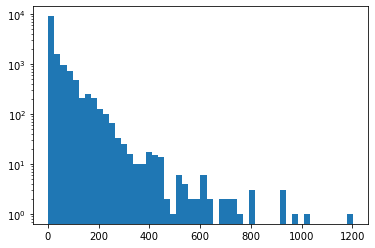

In [12]:
degrees = [val for (node, val) in G.degree()]
plt.figure()
plt.hist(degrees, bins=50)
plt.yscale('log')
plt.show()

In [13]:
print('number of nodes with degree=1 : ', (np.array(degrees)==1).sum())

number of nodes with degree=1 :  1461


In [14]:
print(f'total network size: {len(G)}')
print(f'number of components: {nx.number_connected_components(G)}')
print(f'average cluster coefficient: {nx.average_clustering(G):.2f}')
print(f'network density: {nx.density(G):.3f}')

total network size: 13877
number of components: 1
average cluster coefficient: 0.38
graph transivity (fraction of possible triangles): 0.30
network density: 0.003


In [39]:
pos = nx.spring_layout(Gc, iterations=100, k=2)

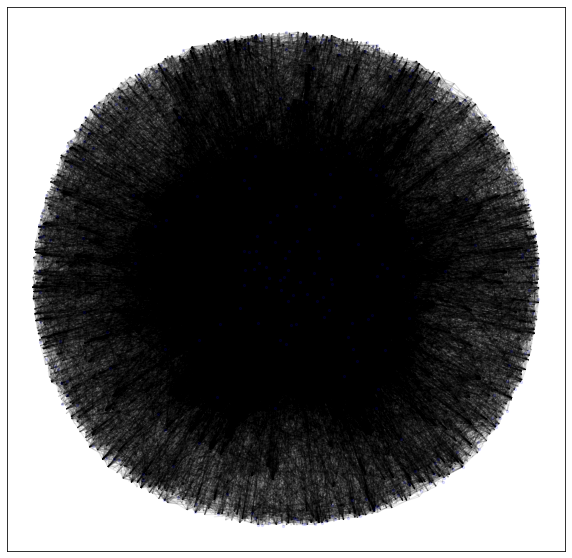

In [40]:
plt.figure(figsize=(10,10)) 
nx.draw_networkx_edges(Gc, pos=pos, alpha=0.1)
nx.draw_networkx_nodes(Gc, pos, nodelist=set(targets.target.values).intersection(Gc.nodes()), node_size=5, node_color='b', node_shape='o', alpha=0.1)
plt.show()